![image.png](attachment:image.png)

# Regressão III - Tarefa

In [1]:
# Importação das bibliotecas
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.interpolate import interp1d # Vamos precisar dessa interpolação

from scipy.stats import pearsonr

In [2]:
# Carregando os dados
df = pd.read_csv('./data/previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [3]:
# Verificando banco
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 2015-01-01 to 2016-03-01
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  750000 non-null  int64  
 1   sexo                   750000 non-null  object 
 2   posse_de_veiculo       750000 non-null  object 
 3   posse_de_imovel        750000 non-null  object 
 4   qtd_filhos             750000 non-null  int64  
 5   tipo_renda             750000 non-null  object 
 6   educacao               750000 non-null  object 
 7   estado_civil           750000 non-null  object 
 8   tipo_residencia        750000 non-null  object 
 9   idade                  750000 non-null  int64  
 10  tempo_emprego          624240 non-null  float64
 11  qt_pessoas_residencia  750000 non-null  float64
 12  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 80.1+ MB


## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [4]:
# Copiando a df original apenas as colunas de interesse
df_copy = df[['tempo_emprego','renda']].sample(50).copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 2016-01-01 to 2015-03-01
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tempo_emprego  41 non-null     float64
 1   renda          50 non-null     float64
dtypes: float64(2)
memory usage: 1.2+ KB


In [5]:
# Verificando missings na renda
df_copy['renda'].isna().sum()

0

In [6]:
# Verificando missing no tempo de emprego
df_copy['tempo_emprego'].isna().sum()

9

In [7]:
# Substituindo os valores faltantes pela média
df_copy.fillna({'tempo_emprego': np.mean(df_copy['tempo_emprego'])}, inplace=True)
df_copy = df_copy.sort_values('renda')

# Verificando missing no tempo de emprego
df_copy['tempo_emprego'].isna().sum()

0

### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [8]:
# Resetando o index da df
df_copy.reset_index(inplace=True)

# Definindo a data_ref como datetime
df_copy['data_ref'] = pd.to_datetime(df_copy['data_ref'])

# Obtendo o log da renda
df_copy['renda_log'] = np.log(df_copy['renda'])

df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   data_ref       50 non-null     datetime64[ns]
 1   tempo_emprego  50 non-null     float64       
 2   renda          50 non-null     float64       
 3   renda_log      50 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.7 KB


In [9]:
# Obtendo o conjunto de teste
df_copy_test = df_copy[df_copy['data_ref'] <= "2015-04-01"]

# Obtendo o conjunto de treino
df_copy_train = df_copy[df_copy['data_ref'] > "2015-04-01"]

print(df_copy_test.shape)
print(df_copy_train.shape)

(14, 4)
(36, 4)


### Primeiro modelo
Prever a renda em seu log. Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

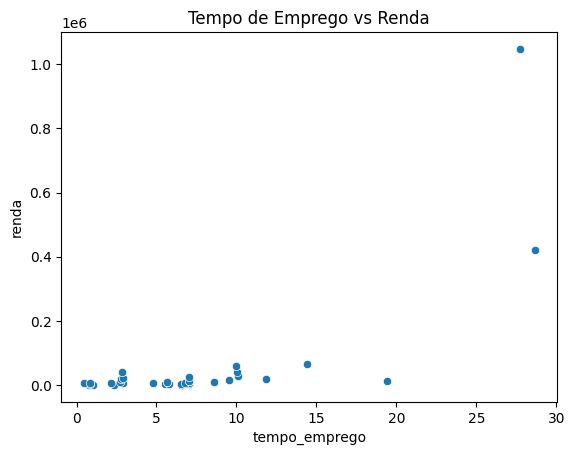

In [10]:
plt.title("Tempo de Emprego vs Renda")
sns.scatterplot(
    x="tempo_emprego",
    y="renda",
    data=df_copy_train
)
plt.show()

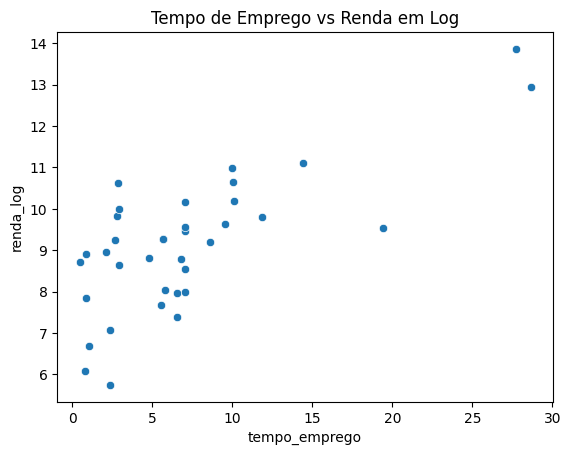

In [11]:
plt.title("Tempo de Emprego vs Renda em Log")
sns.scatterplot(
    x="tempo_emprego",
    y="renda_log",
    data=df_copy_train
)
plt.show()

In [12]:
# Obtendo o modelo de renda em log usando o tempo de emprego
reg = smf.ols("renda_log ~ tempo_emprego", data=df_copy_train).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     41.67
Date:                Sat, 28 Dec 2024   Prob (F-statistic):           2.22e-07
Time:                        13:01:24   Log-Likelihood:                -54.312
No. Observations:                  36   AIC:                             112.6
Df Residuals:                      34   BIC:                             115.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.8134      0.279     28.036      0.000       7.247       8.380
tempo_emprego     0.1859      0.029      6.455      0.000       0.127       0.244
==============================================================================
Omnibus:                        0.873   Durbin-Watson:                   0.708
Prob(Omnibus):                  0.646   Jarque-Bera (JB):                0.926
Skew:                          -0.308   Prob(JB):                        0.629
Kurtosis:                       2.513   Cond. No.                         14.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
print(f"R-squared: {reg.rsquared:.4f}")

R-squared: 0.5507


In [14]:
def esp_vs_obs(res, data, X1, y):
    pred_ols = res.get_prediction(data)
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]

    m_l = pred_ols.summary_frame()["mean_ci_lower"]
    m_u = pred_ols.summary_frame()["mean_ci_upper"]

    _, ax = plt.subplots(figsize=(8, 6))

    plt.title("Estimativas")
    ax.plot(data[X1], data[y], "o", label="Dados observados")
    ax.plot(data[X1], res.predict(data), "r--.", label="Estimativa OLS")
    ax.plot(data[X1], iv_u, "r--", label = 'Banda de confiança para y')
    ax.plot(data[X1], iv_l, "r--")
    ax.plot(data[X1], m_u, "g:", label='Banda de confiança para a média')
    ax.plot(data[X1], m_l, "g:")
    ax.legend(loc="best")
    plt.xlabel(X1)
    plt.ylabel(y)
    plt.show

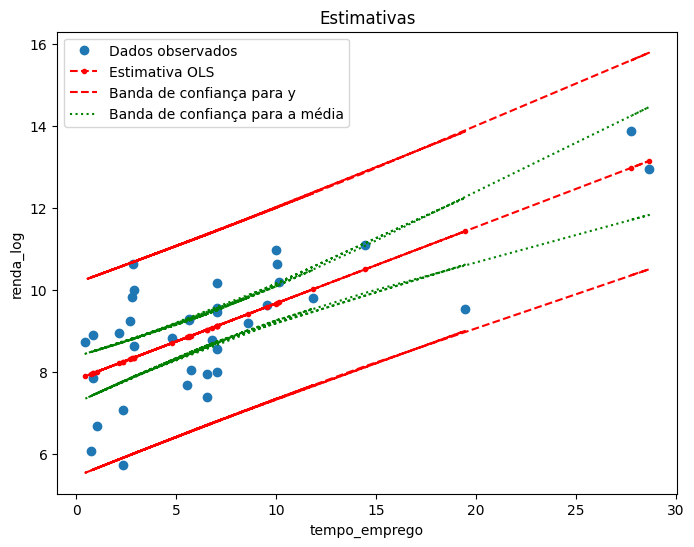

In [15]:
dic_parametros = {
    "res": reg,
    "data": df_copy_train,
    "X1": 'tempo_emprego',
    "y": 'renda_log',
}
esp_vs_obs(**dic_parametros)

### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [16]:
# Inserindo as informações adicionais das estimativas de renda
df_copy['tempo_emprego_cat'], quebras = pd.qcut(df_copy['tempo_emprego'], 10, duplicates='drop', retbins=True)

renda_med = pd.DataFrame()
renda_med['renda_log'] = df_copy.groupby('tempo_emprego_cat', observed=False)['renda_log'].mean()
renda_med['renda_min'] = renda_med['renda_log'] - 2*df_copy.groupby('tempo_emprego_cat', observed=False)['renda_log'].sem()
renda_med['renda_max'] = renda_med['renda_log'] + 2*df_copy.groupby('tempo_emprego_cat', observed=False)['renda_log'].sem()

renda_med.rename(columns={'renda_log':'renda_med'}, inplace=True)
# renda_med.columns = []

tab = df_copy.merge(renda_med, on='tempo_emprego_cat', how='left')
tab.head()

,data_ref,tempo_emprego,renda,renda_log,tempo_emprego_cat,renda_med,renda_min,renda_max
0,2016-03-01,2.347945,312.89,5.745852,"(0.945, 2.622]",7.354507,6.210139,8.498874
1,2016-03-01,0.761644,438.80,6.084044,"(0.347, 0.945]",8.030122,6.992931,9.067313
2,2016-02-01,1.054795,806.45,6.692642,"(0.945, 2.622]",7.354507,6.210139,8.498874
3,2015-10-01,2.320548,1188.71,7.080624,"(0.945, 2.622]",7.354507,6.210139,8.498874
4,2015-01-01,7.063014,1363.92,7.218118,"(7.04, 9.609]",8.686042,7.196437,10.175648


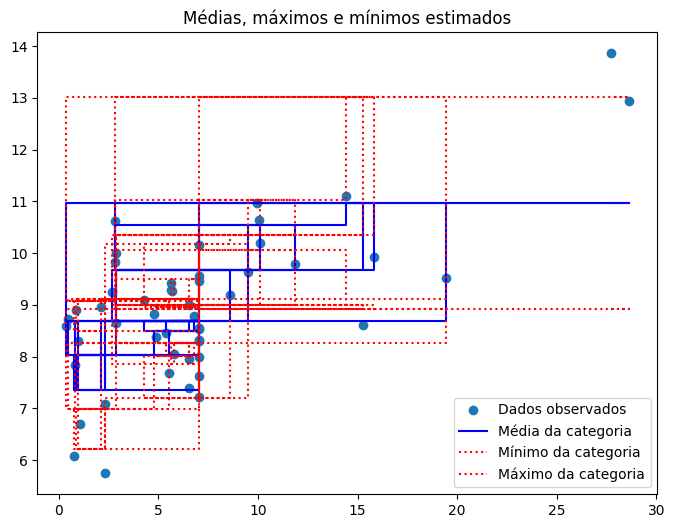

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.title("Médias, máximos e mínimos estimados")
ax.plot(tab['tempo_emprego'], tab['renda_log'], "o", label="Dados observados", alpha=1)
ax.step(tab['tempo_emprego'], tab['renda_med'], "b-", label="Média da categoria", alpha=1)
ax.step(tab['tempo_emprego'], tab['renda_min'], "r:", label="Mínimo da categoria", alpha=1)
ax.step(tab['tempo_emprego'], tab['renda_max'], "r:", label="Máximo da categoria", alpha=1)
ax.legend()
plt.show()

### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


#### Transformação

##### Original

R-squared: 0.5507


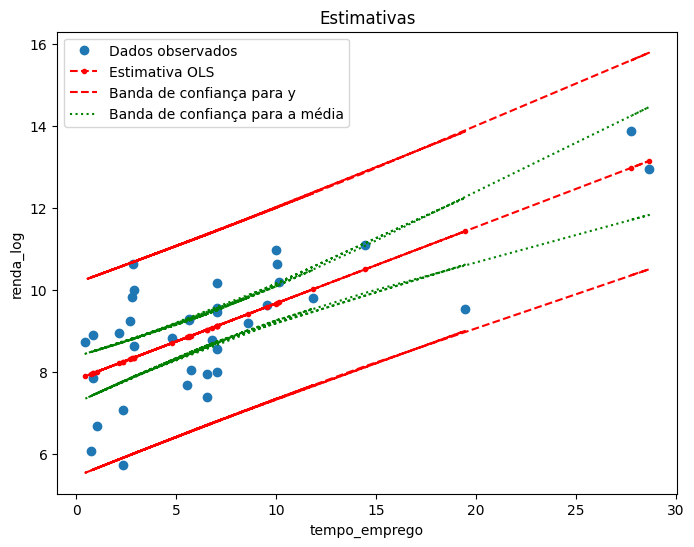

In [18]:
# Dados originais
reg = smf.ols("renda_log ~ tempo_emprego", data=df_copy_train).fit()
print(f"R-squared: {reg.rsquared:.4f}")
dic_parametros = {
    "res": reg,
    "data": df_copy_train,
    "X1": 'tempo_emprego',
    "y": 'renda_log',
}
esp_vs_obs(**dic_parametros)

##### Log

R-squared: 0.4011


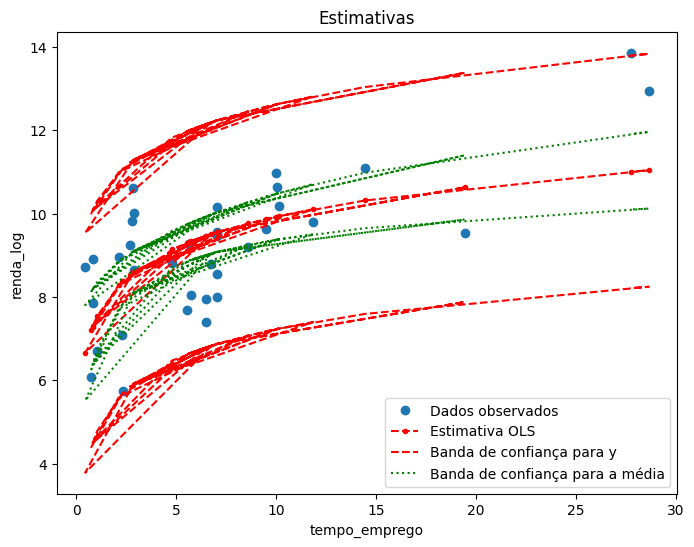

In [19]:
reg = smf.ols("renda_log ~ I(np.log(tempo_emprego))", data=df_copy_train).fit()
print(f"R-squared: {reg.rsquared:.4f}")
dic_parametros = {
    "res": reg,
    "data": df_copy_train,
    "X1": 'tempo_emprego',
    "y": 'renda_log',
}
esp_vs_obs(**dic_parametros)

##### Exponencial

R-squared: 0.4991


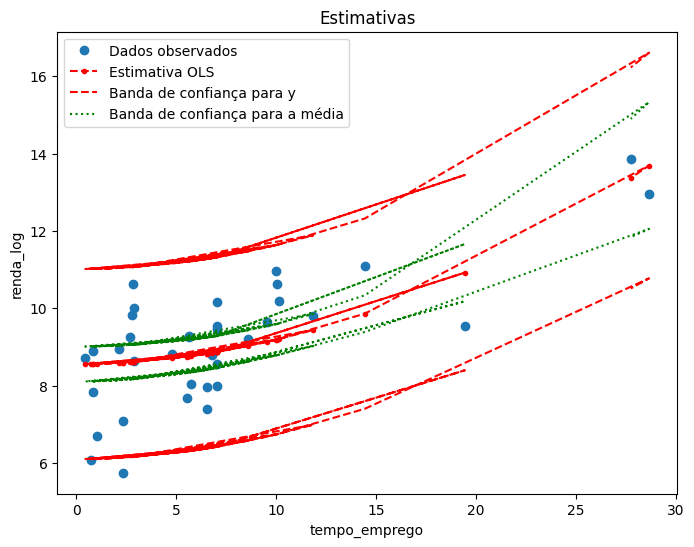

In [20]:
reg = smf.ols("renda_log ~ I(tempo_emprego**2)", data=df_copy_train).fit()
print(f"R-squared: {reg.rsquared:.4f}")
dic_parametros = {
    "res": reg,
    "data": df_copy_train,
    "X1": 'tempo_emprego',
    "y": 'renda_log',
}
esp_vs_obs(**dic_parametros)

##### Função

R-squared: 0.5537


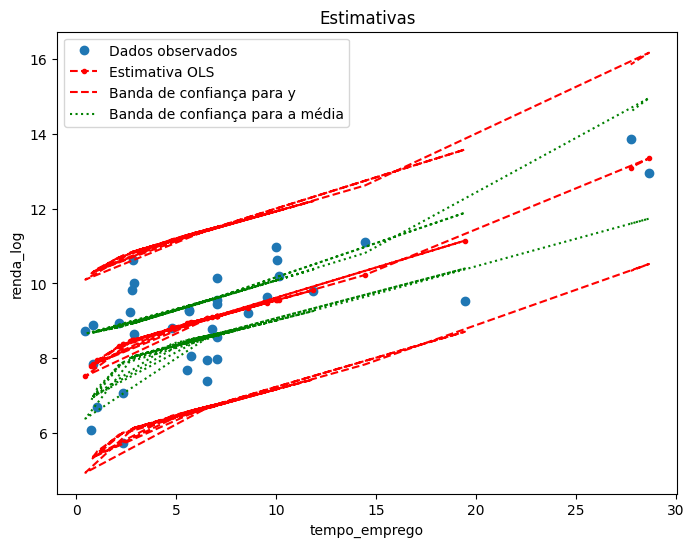

In [21]:
reg = smf.ols("renda_log ~ I(tempo_emprego**2) + I(np.log(tempo_emprego))", data=df_copy_train).fit()
print(f"R-squared: {reg.rsquared:.4f}")
dic_parametros = {
    "res": reg,
    "data": df_copy_train,
    "X1": 'tempo_emprego',
    "y": 'renda_log',
}
esp_vs_obs(**dic_parametros)

#### Lowess

In [22]:
df_copy_train.head()

,data_ref,tempo_emprego,renda,renda_log
0,2016-03-01,2.347945,312.89,5.745852
1,2016-03-01,0.761644,438.80,6.084044
2,2016-02-01,1.054795,806.45,6.692642
3,2015-10-01,2.320548,1188.71,7.080624
5,2016-02-01,6.517808,1619.27,7.389731


/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


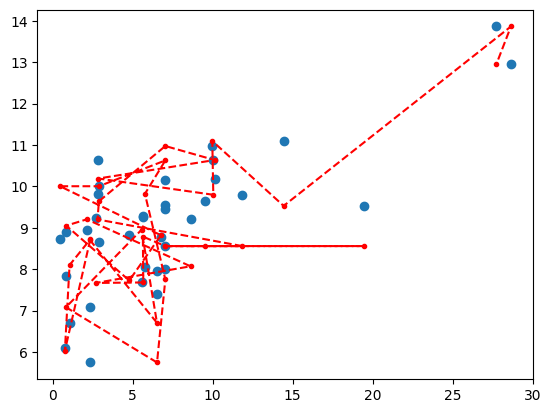

In [23]:
# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df_copy_train['renda_log'], df_copy_train['tempo_emprego'], frac=1/9)

# Valores de Y suavizados
lowess_x = lowess[:, 0]
lowess_y = lowess[:, 1]

# Gráfico
fig, ax = plt.subplots()

ax.plot(df_copy_train['tempo_emprego'], df_copy_train['renda_log'], "o", label="Dados observados", alpha=1)
ax.plot(df_copy_train['tempo_emprego'], lowess_y, "r--.", label="Lowess")
plt.show()

In [24]:
# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_copy_train.loc[:, 'tempo_emprego_lowess'] = f(df_copy_train['tempo_emprego'])
df_copy_train.head()

<ipython-input-24-90a244f10ce2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_train.loc[:, 'tempo_emprego_lowess'] = f(df_copy_train['tempo_emprego'])


,data_ref,tempo_emprego,renda,renda_log,tempo_emprego_lowess
0,2016-03-01,2.347945,312.89,5.745852,5.745852
1,2016-03-01,0.761644,438.80,6.084044,6.029431
2,2016-02-01,1.054795,806.45,6.692642,6.703066
3,2015-10-01,2.320548,1188.71,7.080624,7.080624
5,2016-02-01,6.517808,1619.27,7.389731,7.666658


In [25]:
reg = smf.ols("renda_log ~ tempo_emprego_lowess", data=df_copy_train).fit()

print(f"R-squared: {reg.rsquared:.4f}")

reg.summary()

R-squared: 0.9109


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     347.4
Date:                Sat, 28 Dec 2024   Prob (F-statistic):           2.01e-19
Time:                        13:02:48   Log-Likelihood:                -25.198
No. Observations:                  36   AIC:                             54.40
Df Residuals:                      34   BIC:                             57.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5206      0.470      1.107      0.276      -0.435       1.476
tempo_emprego_lowess     0.9525      0.051     18.638      0.000       0.849       1.056
==============================================================================
Omnibus:                       13.760   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.143
Skew:                           0.859   Prob(JB):                     9.43e-06
Kurtosis:                       6.532   Cond. No.                         52.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

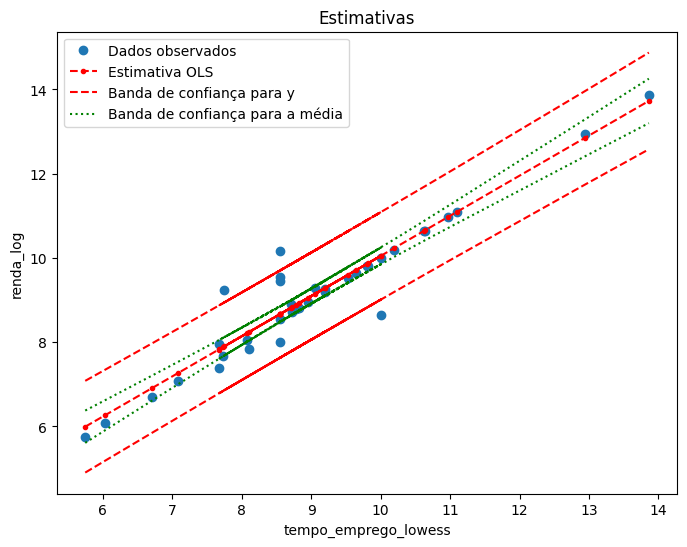

In [26]:
dic_parametros = {
    "res": reg,
    "data": df_copy_train,
    "X1": 'tempo_emprego_lowess',
    "y": 'renda_log',
}
esp_vs_obs(**dic_parametros)

### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

In [27]:
# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df_copy_test['renda_log'], df_copy_test['tempo_emprego'], frac=1/9)

# Valores de Y suavizados
lowess_x = lowess[:, 0]
lowess_y = lowess[:, 1]


# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_copy_test.loc[:, 'tempo_emprego_lowess'] = f(df_copy_test['tempo_emprego'])
df_copy_test.head()

/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
<ipython-input-27-3fde3fc821c5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_test.loc[:, 'tempo_emprego_lowess'] = f(df_copy_test['tempo_emprego'])


,data_ref,tempo_emprego,renda,renda_log,tempo_emprego_lowess
4,2015-01-01,7.063014,1363.92,7.218118,7.218118
6,2015-01-01,7.040294,2035.34,7.618418,7.618418
12,2015-04-01,7.040294,4032.01,8.302020,7.618418
13,2015-03-01,0.956164,4034.49,8.302635,8.302635
14,2015-03-01,7.040294,4104.65,8.319876,7.618418


In [28]:
df_copy_test['renda_log_pred'] = reg.predict(df_copy_test)
df_copy_test.head()

<ipython-input-28-19631a776394>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_test['renda_log_pred'] = reg.predict(df_copy_test)


,data_ref,tempo_emprego,renda,renda_log,tempo_emprego_lowess,renda_log_pred
4,2015-01-01,7.063014,1363.92,7.218118,7.218118,7.396210
6,2015-01-01,7.040294,2035.34,7.618418,7.618418,7.777513
12,2015-04-01,7.040294,4032.01,8.302020,7.618418,7.777513
13,2015-03-01,0.956164,4034.49,8.302635,8.302635,8.429258
14,2015-03-01,7.040294,4104.65,8.319876,7.618418,7.777513


In [29]:
r, p = pearsonr(df_copy_test['renda_log'], df_copy_test['renda_log_pred'])
print(f"Pearson: {r:.2f}\np-value: {p:.2f}")

Pearson: 0.91
p-value: 0.00


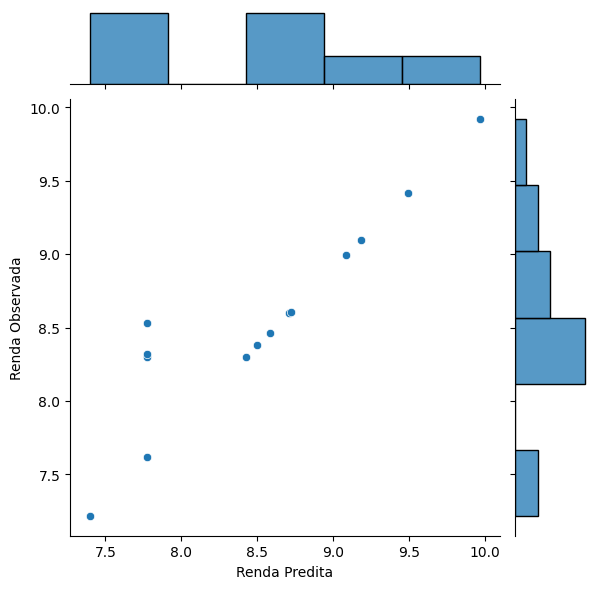

In [30]:
sns.jointplot(
    x='renda_log_pred',
    y='renda_log',
    data=df_copy_test,
)
plt.xlabel("Renda Predita")
plt.ylabel("Renda Observada")
plt.show()

## Conclussão
- O modelo padrão obteve R² de 0,55, o melhor modelo obteve R² de 0,91 com método Lowess.

- Na base de testes o modelo Lowess teve Pearson: 0.91 e p-value: 0.00